In [1]:
#Instalamos pycocotools si no están ya instaladas
#!pip install pycocotools

## Vamos a entrenar la red U-net para segmentar personas en imágenes o vídeos. Para ello vamos a usar las anotaciones de segmentación del dataset de coco. En este cuaderno jupyter  construimos la máscara de segmentación para la clase persona usando el dataset de coco. Con la máscara construida y la imagen segmentada (máscara) guardamos las imágenes en directorios (para entrenamiento y validación). En el otro cuaderno definimos la arquitectura similar a la de U-net y entrenamos un modelo de segmentación semántica.

#### Cargamos las bibliotecas necesarias.

In [2]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import shutil

#### Definimos la ruta al json que contiene las anotaciones. 
#### Usamos la API de coco para seleccionar las imágenes de personas y las anotaciones de segmentación

In [3]:
# Ruta al archivo de anotaciones
ruta_anotaciones = '/media/roger/Datos/asignaturas_master/tfm/coco_dataset/annotations_trainval2017/annotations/instances_train2017.json'

ruta_dataset = '/media/roger/Datos/asignaturas_master/tfm/coco_dataset'

# Cargamos anotaciones de coco
anotaciones_coco = COCO(ruta_anotaciones)

#Obtenemos la categoría ID para la clase personas
categoria_persona = anotaciones_coco.getCatIds(catNms=['person'])

print(categoria_persona)

#El id para la categoría persona es el número 1.

loading annotations into memory...
Done (t=6.58s)
creating index...
index created!
[1]


#### El id para la categoría persona es el número 1. Obtenemos todas las imágenes en las que aparecen personas, así como los datos de segmentación.

In [4]:
# Obtenemos todas los ids/números de imagenes relativos a personas
id_imagenes_personas = anotaciones_coco.getImgIds(catIds=categoria_persona)
#obtenemos una lista de números naturales que hacen referencias a personas.
#Las imágenes tienen el nombre 000000numero.jpg donde número es alguno de los números de la lista (12 dígitos en total)


info_imagenes_personas = anotaciones_coco.loadImgs(id_imagenes_personas)

In [5]:
print(info_imagenes_personas[0])

{'license': 2, 'file_name': '000000262145.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000262145.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-20 02:07:55', 'flickr_url': 'http://farm8.staticflickr.com/7187/6967031859_5f08387bde_z.jpg', 'id': 262145}


##### Obtenemos datos de segmentación

http://images.cocodataset.org/train2017/000000262145.jpg
train2017/000000262145.jpg
/media/roger/Datos/asignaturas_master/tfm/coco_dataset/train2017/000000262145.jpg


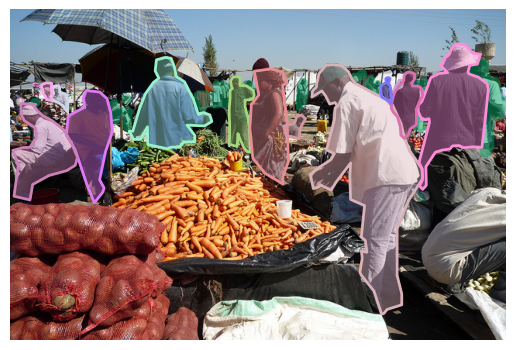

In [6]:
# Obtenemos anotaciones de la imagen seleccionada

ann_ids = anotaciones_coco.getAnnIds(imgIds=id_imagenes_personas[0], catIds=categoria_persona, iscrowd=None)
anns = anotaciones_coco.loadAnns(ann_ids)

#Mostramos la imagen con las máscaras de segmentación

# Mostrar la imagen con las máscaras de segmentación


url = info_imagenes_personas[0]['coco_url']
print(url)
cadena = os.path.join(*url.split('/')[-2:])
print(cadena)
ruta_imagen = os.path.join(ruta_dataset,cadena)
print(ruta_imagen)

imagen =plt.imread(ruta_imagen)
plt.imshow(imagen)
anotaciones_coco.showAnns(anns)
plt.axis('off')
plt.show()


In [7]:
print(anns)

[{'segmentation': [[453.0, 292.1, 457.0, 253.1, 439.0, 245.1, 438.0, 215.1, 439.0, 198.1, 420.0, 223.1, 414.0, 233.1, 401.0, 227.1, 400.0, 226.1, 398.0, 229.1, 391.0, 231.1, 387.0, 213.1, 399.0, 203.1, 404.0, 200.1, 413.0, 194.1, 418.0, 186.1, 408.0, 181.1, 415.0, 154.1, 418.0, 142.1, 419.0, 127.1, 422.0, 125.1, 419.0, 120.1, 412.0, 122.1, 407.0, 112.1, 402.0, 105.1, 389.0, 113.1, 390.0, 105.1, 395.0, 100.1, 395.0, 97.1, 398.0, 83.1, 407.0, 72.1, 417.0, 71.1, 424.0, 72.1, 428.0, 73.1, 436.0, 80.1, 441.0, 90.1, 446.0, 96.1, 456.0, 101.1, 472.0, 110.1, 480.0, 113.1, 493.0, 123.1, 499.0, 136.1, 504.0, 147.1, 509.0, 167.1, 515.0, 182.1, 531.0, 205.1, 532.0, 218.1, 525.0, 229.1, 514.0, 246.1, 499.0, 283.1, 499.0, 307.1, 499.0, 323.1, 499.0, 343.1, 505.0, 367.1, 505.0, 380.1, 505.0, 381.1, 486.0, 387.1, 482.0, 392.1, 479.0, 393.1, 469.0, 363.1, 453.0, 343.1, 451.0, 339.1, 454.0, 321.1, 453.0, 312.1, 460.0, 313.1, 458.0, 298.1, 452.0, 293.1]], 'area': 21258.0, 'iscrowd': 0, 'image_id': 262145

#### Creamos una máscara binaria para la clase persona

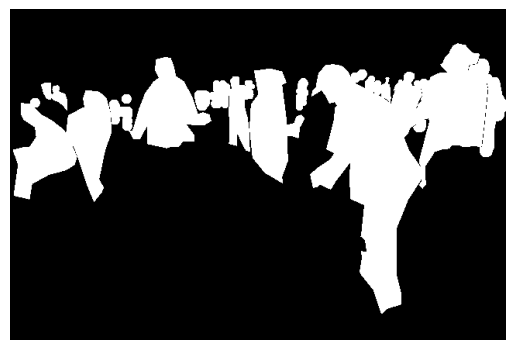

In [8]:
# Crear una máscara binaria para la categoría "persona"
mask = np.zeros((info_imagenes_personas[0]['height'], info_imagenes_personas[0]['width']))

for ann in anns:
    mask = np.maximum(mask, anotaciones_coco.annToMask(ann))

# Mostrar la máscara de segmentación
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

#### Vamos a guardar todas las imágenes y todas las máscaras en las que aparezcan personas.

#### Definimos el directorio donde guardamos las imágenes y las  máscaras para entrenamiento y validación. Creamos los directorios

In [9]:
ruta_actual = os.getcwd()


#En este directorio se almacenan imágenes y máscaras del conjunto de entrenamiento
ruta_entrenamiento = os.path.join(ruta_actual,"entrenamiento")
#En este directorio se almacenan imágenes y máscaras del conjunto de validación
ruta_validacion = os.path.join(ruta_actual,"validacion")

#Creamos la ruta para entrenamiento y validacion

try:
    os.mkdir(ruta_entrenamiento)
except:
    print("El directorio entrenamiento ya existe")

try:
    os.mkdir(ruta_validacion)
except:
    print("El directorio validacion ya existe")

#Creamos las carpetas imágenes y máscaras dentro de entrenamiento y validación


ruta_entrenamiento_imagenes = os.path.join(ruta_entrenamiento,"imagenes")
ruta_entrenamiento_mascaras =os.path.join(ruta_entrenamiento,"mascaras")
ruta_validacion_imagenes = os.path.join(ruta_validacion,"imagenes")
ruta_validacion_mascaras = os.path.join(ruta_validacion,"mascaras")

try:
    os.mkdir(ruta_entrenamiento_imagenes)
except:
    print("El directorio entrenamiento ya existe")

try:
    os.mkdir(ruta_entrenamiento_mascaras)
except:
    print("El directorio entrenamiento ya existe")


try:
    os.mkdir(ruta_validacion_imagenes)
except:
    print("El directorio entrenamiento ya existe")

try:
    os.mkdir(ruta_validacion_mascaras)
except:
    print("El directorio entrenamiento ya existe")


    



#### Guardamos todas las imágenes que contienen personas y las máscaras para las mismas. 
Iteramos sobre la lista info_imagenes_personas para obtener los datos de las imágenes que contienen personas. Construimos la máscara de segmentación. Definimos una función para hacerlo (se debe hacer sobre el conjunto de entrenamiento y sobre el conjunto de validación)

In [10]:
ruta_dataset = '/media/roger/Datos/asignaturas_master/tfm/coco_dataset'
ruta_anotaciones_entrenamiento = '/media/roger/Datos/asignaturas_master/tfm/coco_dataset/annotations_trainval2017/annotations/instances_train2017.json'
ruta_anotaciones_validacion = '/media/roger/Datos/asignaturas_master/tfm/coco_dataset/annotations_trainval2017/annotations/instances_val2017.json'

def extraccion_imagenes_mascaras(ruta_json_anotaciones, ruta_dataset_coco):
    # Cargamos anotaciones de coco
    coco = COCO(ruta_json_anotaciones)
    
    #Obtenemos la categoría ID para la clase personas (ya sabemos que es el número 1)
    categoria_persona = coco.getCatIds(catNms=['person'])

    # Obtenemos todas los ids/números de imagenes relativos a personas
    id_imagenes_personas = coco.getImgIds(catIds=categoria_persona)
    #obtenemos una lista de números naturales que hacen referencias a personas.
    #Las imágenes tienen el nombre 000000numero.jpg donde número es alguno de los números de la lista (12 dígitos en total)

    informacion_imagenes_personas = coco.loadImgs(id_imagenes_personas)

    
    for info in informacion_imagenes_personas:
        ann_ids = coco.getAnnIds(imgIds=info['id'], catIds=categoria_persona, iscrowd=None)
        anns = coco.loadAnns(ann_ids)

        url = info['coco_url']
        nombre_imagen = os.path.join(*url.split('/')[-1:])[:-4]
        ruta_relativa = os.path.join(*url.split('/')[-2:])
        tipo_imagen = os.path.join(*url.split('/')[-2:-1]) #El tipo es train2017 o val2017

        #Obtenemos la ruta a la imagen en el dataset de coco que tenemos ya descargado
        ruta_imagen = os.path.join(ruta_dataset_coco,ruta_relativa)

        #Obtenemos la máscara binaria para la imagen y la guardamos

        imagen = cv2.imread(ruta_imagen)
        alto, ancho, _ =imagen.shape
        
        # Crear una máscara binaria para la categoría "persona"
        mascara = np.zeros((alto, ancho))

        for ann in anns:
            mascara = np.maximum(mascara, coco.annToMask(ann))

        #Guardamos la imagen y la máscara en la ruta adecuada (entrenamiento o validacion)
        if tipo_imagen == 'train2017':
            #Copiamos la imagen original
            shutil.copy(ruta_imagen,ruta_entrenamiento_imagenes)
            # Escalamos los valores de 0 y 1 a 0 y 255
            mascara = mascara * 255
            ruta_mascara = os.path.join(ruta_entrenamiento_mascaras,nombre_imagen+ '_mascara.jpg')
            # Guardamos la máscara como imagen jpg
            cv2.imwrite(ruta_mascara, mascara)

            
        elif tipo_imagen == 'val2017':
            #Copiamos la imagen original
            shutil.copy(ruta_imagen,ruta_validacion_imagenes)
            # Escalamos los valores de 0 y 1 a 0 y 255
            mascara = mascara * 255
            ruta_mascara = os.path.join(ruta_validacion_mascaras,nombre_imagen+ '_mascara.jpg')
            # Guardamos la máscara como imagen jpg
            cv2.imwrite(ruta_mascara, mascara)

        else:
            print("Hubo un error al guardar la imagen original en los directorios de entrenamiento o validación")


#### Guardamos imágenes y máscaras para entrenamiento

In [11]:
extraccion_imagenes_mascaras(ruta_anotaciones_entrenamiento,ruta_dataset)

loading annotations into memory...
Done (t=6.35s)
creating index...
index created!


#### Guardamos imágenes y máscaras para el conjunto de validación

In [12]:
extraccion_imagenes_mascaras(ruta_anotaciones_validacion,ruta_dataset)

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!
